<a href="https://colab.research.google.com/github/uwituzeb/healthcare-facility-planning-capstone-project/blob/main/modelNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enhancing Health Equity: A data-driven approach for Health Facility Placement in Rwanda


This notebook demonstrates the development of an ML model to support healthcare facility planning. It involves:



*   Visualizing and cleaning geospatial data images
*   Designing a model to classify healthcare facilities from satellite imagery


*   Evaluating model performance







In [3]:
# install libraries
!pip install earthengine-api geemap rasterio patchify torchvision

In [4]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import time
import rasterio
import seaborn as sns
import folium
import geemap.foliumap as geemap
import ee
import os
import torch
from torch.utils.data import Dataset, DataLoader
from patchify import patchify
from torchvision import transforms
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.cluster import KMeans

In [3]:
# Authenticate and initialize google earth engine
ee.Authenticate()
ee.Initialize(project='rwanda-health-planning')


In [4]:
# Define Rwandan boundaries
Rwanda = ee.FeatureCollection('FAO/GAUL/2015/level0').filter(ee.Filter.eq('ADM0_NAME', 'Rwanda'))

In [5]:
# Cloud masking to reduce noise
def mask_s2_clouds(image):
  qa = image.select('QA60')
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11
  mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  )

  return image.updateMask(mask).divide(10000)

In [8]:
# Load sentinel-2 imagery and apply cloud mask
sentinel2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
    .filterBounds(Rwanda)\
    .filterDate('2025-01-01', '2025-09-29')\
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))\
    .median()\
    .select(['B4', 'B3', 'B2'])



In [9]:
print(Rwanda.size().getInfo())

1


In [10]:
# Visualize map of Rwanda
map_center = Rwanda.geometry().centroid().coordinates().get(0).getInfo(), Rwanda.geometry().centroid().coordinates().get(1).getInfo()
my_map = geemap.Map(center=map_center, zoom=8)
my_map.addLayer(sentinel2, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'Sentinel-2 RGB')
my_map.addLayerControl()
my_map

In [15]:
# Load ESA World cover for labels
worldcover = ee.Image('ESA/WorldCover/v200/2021').select('Map').clip(Rwanda)


In [17]:
# Export params for both sentinel and label images
region = Rwanda.geometry().bounds().getInfo()['coordinates']

export_params = {
    'image': sentinel2,
    'description': 'rwanda_sentinel2_2025',
    'scale': 10,
    'region': region,
    'folder': 'earth_engine',
    'maxPixels': 1e13,
    'fileFormat': 'GeoTIFF'
}

export_params_label = {
    'image': worldcover,
    'description': 'rwanda_worldcover_2021',
    'scale': 10,
    'region': region,
    'folder': 'earth_engine',
    'maxPixels': 1e13,
    'fileFormat': 'GeoTIFF'
}

In [21]:
# Export to Google Drive
task = ee.batch.Export.image.toDrive(**export_params)

task.start()
print("Exporting to Google Drive...")

print("Monitoring task status...")
while task.active():
    status = task.status()
    print(f"Task status: {status['state']}")
    if status['state'] == 'FAILED':
        print(f"Task failed: {status.get('error_message', 'Unknown error')}")
        break
    time.sleep(30)

if task.status()['state'] == 'COMPLETED':
    print("Export completed successfully!")
else:
    print("Export did not complete successfully.")

Exporting to Google Drive...
Monitoring task status...
Task status: READY


KeyboardInterrupt: 

In [2]:
sentinel_path = '/content/drive/MyDrive/earth_engine/Rwanda_sentinel2_2025-0000000000-0000000000.tif'

with rasterio.open(sentinel_path) as src:
    s2 = src.read()
    s2_meta = src.meta

print(f"Sentinel shape: {s2.shape}")
red = s2[0, :, :]
green = s2[1, :, :]
blue = s2[2, :, :]

# stack into RGB-array for visualization
data = np.dstack((red, green, blue))

NameError: name 'rasterio' is not defined

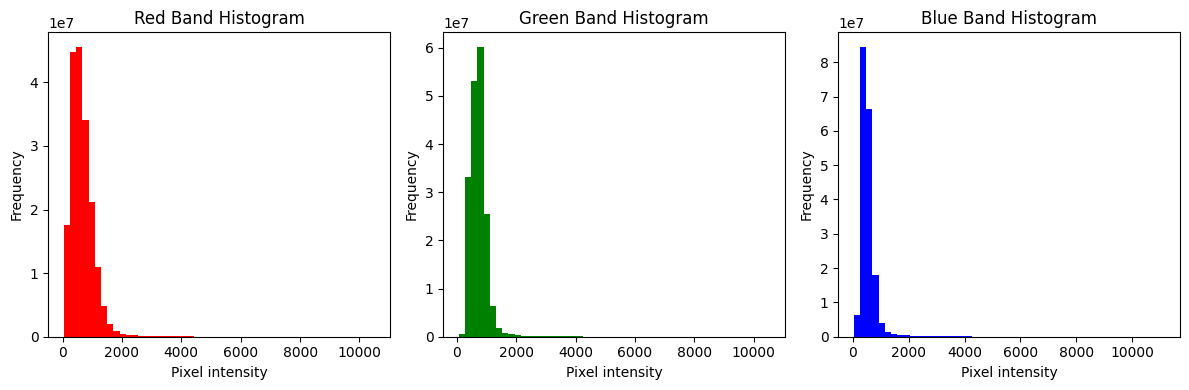

In [25]:
# Histogram of rgb bands

plt.figure(figsize=(12, 4))
for i, (band, name) in enumerate(zip([red, green, blue], ['Red', 'Green', 'Blue'])):
    plt.subplot(1, 3, i+1)
    plt.hist(band.flatten(), bins=50, color=name.lower())
    plt.title(f'{name} Band Histogram')
    plt.xlabel('Pixel intensity')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [1]:
# Prepare features for training (flatten to 2D array)
height, width = red.shape
X = np.column_stack([red.flatten(), green.flatten(), blue.flatten()])
print(f"Total samples: {X.shape[0]}")

model = KMeans(n_clusters=5, init='k-means++', random_state=42, n_init=10)

NameError: name 'red' is not defined

In [ ]:
# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

In [13]:
# Train the model
model.fit(X)

NameError: name 'X' is not defined

In [ ]:
# Assign cluster labels to pixels
labels = model.labels_.reshape(height, width)

In [ ]:
# Calculate metrics
score = silhouette_score(X, model.labels_)
print(f"Silhouette Score: {score:.4f}")

# Visualize clustering result
plt.figure(figsize=(10, 10))
plt.imshow(labels, cmap='viridis')
plt.title('K-Means Clustering of Rwanda Sentinel-2 Data')
plt.axis('off')
plt.show()